# 課題『Car Fuel Consumption』
URL：https://www.kaggle.com/anderas/car-consume  
氏名：s.fukasawa

### 目次
 1. 課題の概要
 1. データセットの確認
 1. 前処理
 1. 目的変数と説明変数の関係  
 1. アルゴリズムの実装
 1. 予測精度の確認

### 1. 課題の概要
　問題設定：100kmあたりのガソリン消費量(consume)を予測  

### 2. データセットの確認
#### ・データ項目
|項番|データ項目    |説明    |
|:--:|:--:          |:--:    | 
|  1 | distance     | 走行距離(km/h)|
|  2 | consume      | ガソリン消費量(L/100km)|
|  3 | speed        | 平均速度（km/h）|
|  4 | temp_inside  | 車内温度（℃） |
|  5 | temp_outside | 車外温度（℃）|
|  6 | specials     | 特記事項|
|  7 | gas_type     | ガソリンの種類|
|  8 | AC           | 空調|
|  9 | rain         | 雨天|
| 10 | sun          | 晴天|
| 11 | refill liters| 給油量（L）|
| 12 | refill gas   | 給油したガソリンの種類|



#### ・データセットの読み込み

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold # 交差検証法に関する関数
from sklearn.metrics import mean_squared_error, mean_absolute_error # 回帰問題における性能評価に関する関数
from sklearn import linear_model
from sklearn.pipeline import make_pipeline

In [2]:
df = pd.read_csv("car-consume/measurements.csv")[['distance', 'consume', 'speed', 'temp_inside', 'temp_outside', 'specials', 'gas_type','AC','rain','sun','refill liters','refill gas']]

In [3]:
display(df.head())

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
0,28,5,26,"21,5",12,NaN,E10,0,0,0,45,E10
1,12,"4,2",30,"21,5",13,NaN,E10,0,0,0,NaN,NaN
2,"11,2","5,5",38,"21,5",15,NaN,E10,0,0,0,NaN,NaN
3,"12,9","3,9",36,"21,5",14,NaN,E10,0,0,0,NaN,NaN
4,"18,5","4,5",46,"21,5",15,NaN,E10,0,0,0,NaN,NaN


In [4]:
df.describe(include='all')

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
count,388,388,388.000000,376,388.000000,93,388,388.000000,388.000000,388.000000,13,13
unique,174,43,NaN,13,NaN,12,2,NaN,NaN,NaN,10,2
top,"11,8",5,NaN,"21,5",NaN,rain,SP98,NaN,NaN,NaN,45,SP98
freq,37,27,NaN,133,NaN,32,228,NaN,NaN,NaN,2,8
mean,NaN,NaN,41.927835,NaN,11.358247,NaN,NaN,0.077320,0.123711,0.082474,NaN,NaN
std,NaN,NaN,13.598524,NaN,6.991542,NaN,NaN,0.267443,0.329677,0.275441,NaN,NaN
min,NaN,NaN,14.000000,NaN,-5.000000,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN
25%,NaN,NaN,32.750000,NaN,7.000000,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN
50%,NaN,NaN,40.500000,NaN,10.000000,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN
75%,NaN,NaN,50.000000,NaN,16.000000,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 12 columns):
distance         388 non-null object
consume          388 non-null object
speed            388 non-null int64
temp_inside      376 non-null object
temp_outside     388 non-null int64
specials         93 non-null object
gas_type         388 non-null object
AC               388 non-null int64
rain             388 non-null int64
sun              388 non-null int64
refill liters    13 non-null object
refill gas       13 non-null object
dtypes: int64(5), object(7)
memory usage: 36.5+ KB


[メモ] 
量的変数だが小数点が”,”で表記されているために変数の型がobjectになっているもの  
　…distance, consume, temp_inside  
　⇒”,”から”.”への置換が必要　＆　float型へのキャストが必要

質的変数だが数値として扱いたいもの  
　…gas_type  
　⇒ダミーデータに置き換える("E10"…0 ,"SP98"…1 として扱う)

欠損値があるもの  
　…temp_inside, specials, refill liters, refill gas  
　⇒temp_insideは欠損値を埋める（とりあえずtemp_inside全体の平均値で埋める）  
　⇒specials,refill liters, refill gasは使用しないので無視

### 3. 前処理

～やること～  
・データの体裁を整える  
・標準化  
・前処理の結果確認

#### ・データの体裁を整える

In [6]:
# distance 前処理
df['distance'] = df['distance'].apply(lambda x: x.replace(",", "."))
df['distance'] = df['distance'].astype(np.float)

In [7]:
# consume 前処理
df['consume'] = df['consume'].apply(lambda x: x.replace(",", "."))
df['consume'] = df['consume'].astype(np.float)

In [8]:
# temp_inside 前処理 1/3
 # 欠損値以外の型を確認 
print("欠損値以外の値の例… ",df.at[0,'temp_inside'])
print("欠損値以外の型    … ",type(df.at[0,'temp_inside']))    
print()    
 # 欠損値の型を確認
print("欠損値            … ",df.at[93,'temp_inside'])
print("欠損値の型        … ",type(df.at[93,'temp_inside']))

欠損値以外の値の例…  21,5
欠損値以外の型    …  <class 'str'>

欠損値            …  nan
欠損値の型        …  <class 'float'>


In [9]:
# temp_inside 前処理 2/3
 # ","から"."へ置換
 # 欠損値(float型)を置換しようとするとするとエラーが出るらしいので、欠損値以外（str型）だけ置換する
for i in range(len(df) - 1):
    temp_inside_buf = df.at[i, 'temp_inside']                    #１行抽出→型判定
    if(type(temp_inside_buf) is str):                       
        df.at[i, 'temp_inside'] = df.at[i, 'temp_inside'].replace(",", ".")     

 # float型にキャスト
df['temp_inside'] = df['temp_inside'].astype(np.float)

 # 欠損値を埋める（temp_insideの平均値で埋める）
df['temp_inside']  = df['temp_inside'].fillna(df['temp_inside'].mean())

In [10]:
# temp_inside 前処理 3/3
 # 欠損値(だったところ)に平均値が入ったことの確認
print("(もと)欠損値      … ",df.at[93,'temp_inside'])
print("(もと)欠損値の型  … ",type(df.at[93,'temp_inside']))

(もと)欠損値      …  21.929521276595743
(もと)欠損値の型  …  <class 'numpy.float64'>


In [11]:
# gas_type 前処理
df.loc[df['gas_type'] == 'E10', 'gas_type'] = 0
df.loc[df['gas_type'] == 'SP98', 'gas_type'] =1 

#### ・標準化

In [12]:
# 標準化とは、平均を引いて、標準偏差で割る操作
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
df[["distance"]]     = stdsc.fit_transform(df[["distance"]].values)
df[["speed"]]        = stdsc.fit_transform(df[["speed"]].values)
df[["temp_inside"]]  = stdsc.fit_transform(df[["temp_inside"]].values)
df[["temp_outside"]] = stdsc.fit_transform(df[["temp_outside"]].values)
df[["gas_type"]]     = stdsc.fit_transform(df[["gas_type"]].values)
df[["AC"]]           = stdsc.fit_transform(df[["AC"]].values)
df[["rain"]]         = stdsc.fit_transform(df[["rain"]].values)
df[["sun"]]          = stdsc.fit_transform(df[["sun"]].values)

C:\Users\sub-pc\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


#### ・前処理の結果確認

In [13]:
display(df.head())

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
0,0.368714,5.0,-1.172804,-0.432382,0.091908,NaN,-1.193734,-0.28948,-0.375735,-0.299813,45,E10
1,-0.338044,4.2,-0.878274,-0.432382,0.235123,NaN,-1.193734,-0.28948,-0.375735,-0.299813,NaN,NaN
2,-0.373381,5.5,-0.289216,-0.432382,0.521552,NaN,-1.193734,-0.28948,-0.375735,-0.299813,NaN,NaN
3,-0.298288,3.9,-0.436480,-0.432382,0.378338,NaN,-1.193734,-0.28948,-0.375735,-0.299813,NaN,NaN
4,-0.050923,4.5,0.299843,-0.432382,0.521552,NaN,-1.193734,-0.28948,-0.375735,-0.299813,NaN,NaN


In [14]:
df.describe(include='all')

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
count,3.880000e+02,388.000000,3.880000e+02,3.880000e+02,3.880000e+02,93,3.880000e+02,3.880000e+02,3.880000e+02,3.880000e+02,13,13
unique,NaN,NaN,NaN,NaN,NaN,12,NaN,NaN,NaN,NaN,10,2
top,NaN,NaN,NaN,NaN,NaN,rain,NaN,NaN,NaN,NaN,45,SP98
freq,NaN,NaN,NaN,NaN,NaN,32,NaN,NaN,NaN,NaN,2,8
mean,1.322682e-16,4.912371,2.392130e-16,-3.834275e-15,4.475229e-16,NaN,-4.028851e-16,4.967390e-16,-2.646795e-16,-1.133114e-15,NaN,NaN
std,1.001291e+00,1.033172,1.001291e+00,1.001291e+00,1.001291e+00,NaN,1.001291e+00,1.001291e+00,1.001291e+00,1.001291e+00,NaN,NaN
min,-8.106875e-01,3.300000,-2.056392e+00,-2.949035e+00,-2.342740e+00,NaN,-1.193734e+00,-2.894804e-01,-3.757346e-01,-2.998127e-01,NaN,NaN
25%,-3.468780e-01,4.300000,-6.757855e-01,-4.323823e-01,-6.241648e-01,NaN,-1.193734e+00,-2.894804e-01,-3.757346e-01,-2.998127e-01,NaN,NaN
50%,-2.231955e-01,4.700000,-1.051348e-01,7.094818e-02,-1.945209e-01,NaN,8.377078e-01,-2.894804e-01,-3.757346e-01,-2.998127e-01,NaN,NaN
75%,-2.883725e-02,5.300000,5.943724e-01,5.742786e-01,6.647669e-01,NaN,8.377078e-01,-2.894804e-01,-3.757346e-01,-2.998127e-01,NaN,NaN


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 12 columns):
distance         388 non-null float64
consume          388 non-null float64
speed            388 non-null float64
temp_inside      388 non-null float64
temp_outside     388 non-null float64
specials         93 non-null object
gas_type         388 non-null float64
AC               388 non-null float64
rain             388 non-null float64
sun              388 non-null float64
refill liters    13 non-null object
refill gas       13 non-null object
dtypes: float64(9), object(3)
memory usage: 36.5+ KB


distance


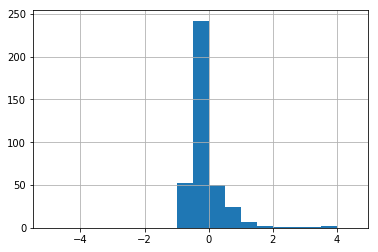

speed


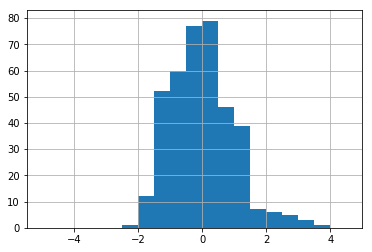

temp_inside


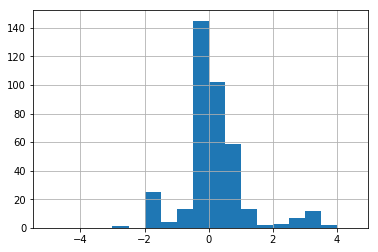

temp_outside


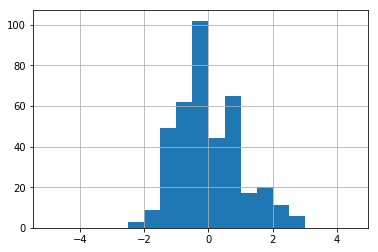

gas_type


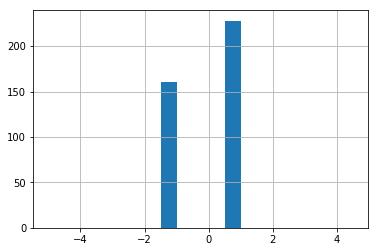

AC


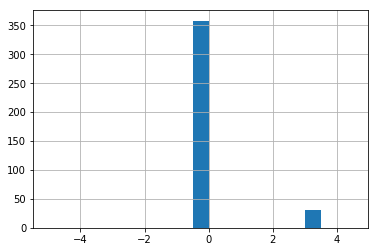

rain


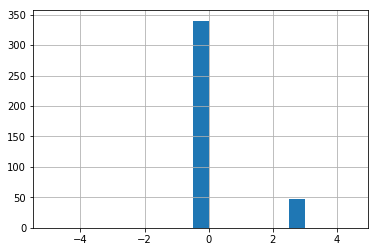

sun


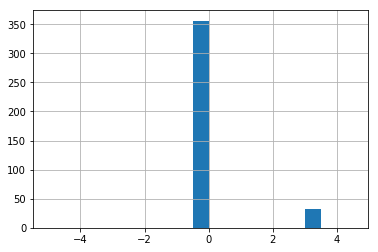

In [16]:
# 標準化されていることを確認
print("distance")
df["distance"].hist(bins=np.arange(-5,5,0.5))
plt.show()
print("speed")
df["speed"].hist(bins=np.arange(-5,5,0.5))
plt.show()
print("temp_inside")
df["temp_inside"].hist(bins=np.arange(-5,5,0.5))
plt.show()
print("temp_outside")
df["temp_outside"].hist(bins=np.arange(-5,5,0.5))
plt.show()
print("gas_type")
df["gas_type"].hist(bins=np.arange(-5,5,0.5))
plt.show()
print("AC")
df["AC"].hist(bins=np.arange(-5,5,0.5))
plt.show()
print("rain")
df["rain"].hist(bins=np.arange(-5,5,0.5))
plt.show()
print("sun")
df["sun"].hist(bins=np.arange(-5,5,0.5))
plt.show()

### 4. 目的変数と説明変数の関係

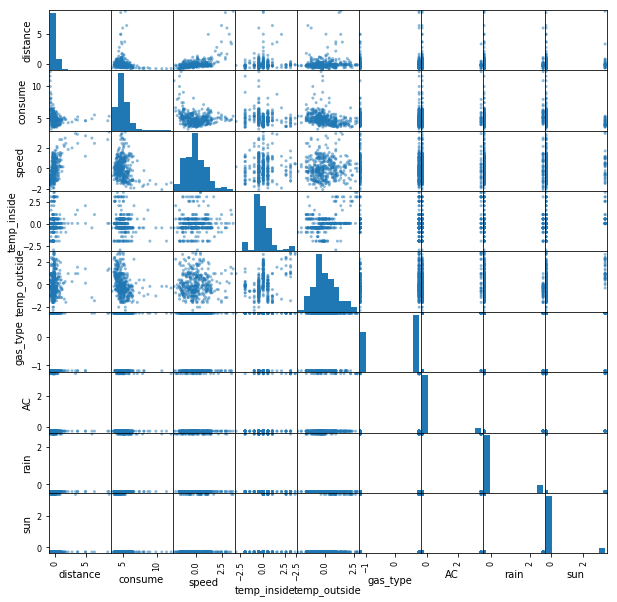

In [17]:
# 散布図行列を書いてみる（数値データの部分だけプロットされるらしい）
pd.plotting.scatter_matrix(df, figsize=(10,10))
plt.show()

In [18]:
# 相関係数を確認
df.corr()

,distance,consume,speed,temp_inside,temp_outside,gas_type,AC,rain,sun
distance,1.000000,-0.128967,0.562299,0.075178,0.088175,-0.053411,-0.025738,-0.019791,0.081120
consume,-0.128967,1.000000,-0.227866,-0.160623,-0.320811,-0.015327,0.096591,0.248118,-0.170667
speed,0.562299,-0.227866,1.000000,0.059293,0.015411,-0.097360,-0.035408,0.009489,0.081618
temp_inside,0.075178,-0.160623,0.059293,1.000000,0.359500,0.010198,0.297376,-0.036937,0.242248
temp_outside,0.088175,-0.320811,0.015411,0.359500,1.000000,0.148705,0.167562,-0.186315,0.346903
gas_type,-0.053411,-0.015327,-0.097360,0.010198,0.148705,1.000000,0.105285,0.060328,0.022761
AC,-0.025738,0.096591,-0.035408,0.297376,0.167562,0.105285,1.000000,0.242915,0.088598
rain,-0.019791,0.248118,0.009489,-0.036937,-0.186315,0.060328,0.242915,1.000000,-0.112650
sun,0.081120,-0.170667,0.081618,0.242248,0.346903,0.022761,0.088598,-0.112650,1.000000


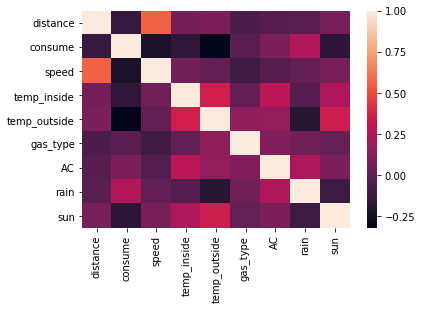

In [19]:
# 相関係数をヒートマップにして可視化
sns.heatmap(df.corr())
plt.show()

### 5. アルゴリズムの実装

～やること～  
交差検証法で汎化誤差を確認するアルゴリズムを作成  
モデルを差し替えて検証できるようにした（つもり）

In [20]:
def predict(model):

    # 係数を求める
    y = df["consume"].values
    X = df[["distance", "speed", "temp_inside", "temp_outside",\
            "gas_type","AC", "rain", "sun"]].values

    n_split = 5 # グループ数を設定

    cross_valid_mse = 0
    cross_valid_mae = 0
    cross_valid_rmse = 0
    split_num = 1

    # テスト役を交代させながら学習と評価を繰り返す
    for train_idx, test_idx in KFold(n_splits=n_split, random_state=1234).split(X, y):
        X_train, y_train = X[train_idx], y[train_idx] #学習用データ
        X_test, y_test = X[test_idx], y[test_idx]     #テスト用データ
    
        # 学習用データを使って線形回帰モデルを学習
        #model = LinearRegression(fit_intercept=False)
        model.fit(X_train, y_train)

        # テストデータに対する予測を実行
        y_pred_test = model.predict(X_test)
    
        # テストデータに対するMSE,MAE,RMSEを計算
        mse = mean_squared_error(y_test, y_pred_test) 
        mae = mean_absolute_error(y_test, y_pred_test)
        rmse = np.sqrt(mse)
        #print("Fold %s : MSE = %s, MAE = %s, RMSE = %s"% (split_num, round(mse,3), round(mae, 3), round(rmse, 3)) )   
    
        cross_valid_mse += mse #後で平均を取るためにMSEを加算    
        cross_valid_mae += mae #後で平均を取るためにMAEを加算
        cross_valid_rmse += rmse #後で平均を取るためにRMSEを加算
        split_num += 1

    # 平均値を最終的な汎化誤差値とする
    final_mse = cross_valid_mse / n_split
    final_mae = cross_valid_mae / n_split
    final_rmse = cross_valid_rmse / n_split
    print("Cross Validation MSE = %s"%round(final_mse, 3))
    print("Cross Validation MAE = %s"%round(final_mae, 3))
    print("Cross Validation RMSE = %s"%round(final_rmse, 3))
    print()
    return

### 6. 予測精度の確認

～やること～  
正則化なしと正則化あり（ElasticNet）で予測精度を比較してみる  
ElasticNetはL1とL2の割合を変えていくつか試す  

In [21]:
#正則化なし
predict(LinearRegression(fit_intercept=False))

Cross Validation MSE = 50.156
Cross Validation MAE = 6.546
Cross Validation RMSE = 6.853



In [22]:
#ElasticNet （L1_0.1,L2_0.9）
predict(linear_model.ElasticNet(alpha=1 , l1_ratio=0.1, max_iter=1e8))

Cross Validation MSE = 1.015
Cross Validation MAE = 0.659
Cross Validation RMSE = 0.989



In [23]:
#ElasticNet （L1_0.2,L2_0.8）
predict(linear_model.ElasticNet(alpha=1 , l1_ratio=0.2, max_iter=1e8))

Cross Validation MSE = 1.092
Cross Validation MAE = 0.691
Cross Validation RMSE = 1.027



In [24]:
#ElasticNet （L1_0.3,L2_0.7）
predict(linear_model.ElasticNet(alpha=1 , l1_ratio=0.3, max_iter=1e8))

Cross Validation MSE = 1.126
Cross Validation MAE = 0.707
Cross Validation RMSE = 1.044



In [25]:
#ElasticNet （L1_0.4,L2_0.6）
predict(linear_model.ElasticNet(alpha=1, l1_ratio=0.4, max_iter=1e8))

Cross Validation MSE = 1.137
Cross Validation MAE = 0.711
Cross Validation RMSE = 1.049



In [26]:
#ElasticNet （L1_0.5,L2_0.5）
predict(linear_model.ElasticNet(alpha=1 , l1_ratio=0.5, max_iter=1e8))

Cross Validation MSE = 1.137
Cross Validation MAE = 0.711
Cross Validation RMSE = 1.049



In [27]:
#ElasticNet （L1_0.6,L2_0.4）
predict(linear_model.ElasticNet(alpha=1 , l1_ratio=0.6, max_iter=1e8))

Cross Validation MSE = 1.137
Cross Validation MAE = 0.711
Cross Validation RMSE = 1.049



In [28]:
#ElasticNet （L1_0.7,L2_0.3）
predict(linear_model.ElasticNet(alpha=1 , l1_ratio=0.7, max_iter=1e8))

Cross Validation MSE = 1.137
Cross Validation MAE = 0.711
Cross Validation RMSE = 1.049



In [29]:
#ElasticNet （L1_0.8,L2_0.2）
predict(linear_model.ElasticNet(alpha=1 , l1_ratio=0.8, max_iter=1e8))

Cross Validation MSE = 1.137
Cross Validation MAE = 0.711
Cross Validation RMSE = 1.049



In [30]:
#ElasticNet （L1_0.9,L2_0.1）
predict(linear_model.ElasticNet(alpha=1 , l1_ratio=0.9, max_iter=1e8))

Cross Validation MSE = 1.137
Cross Validation MAE = 0.711
Cross Validation RMSE = 1.049



[メモ]  
正則化なしに比べて、正則化（ElasticNet）を実施したほうが誤差はとても少なくなった  
ElasticNetでL1とL2の割合を変えてみたがあまり変化がなかった…  
でもL1の割合が低いほうが誤差が少なくなる傾向にあるので、ElasticNetではなくてRidge（L2正則化）を使うと誤差がもっと減るかもしれない？